## Tech_Layoffs_EDA
- In this notebook you will find all the process of loading, migrating and manipulating data of our dataset with the MySQL database
- All the modifications that were made to the dataset were made by means of queries in python, no SQL query was executed in a terminal own SQL,(The 3 queries that we made to our table in the database were made in python)
- The analysis carried out in this EDA involves re-frying and being able to implement a first look at the behavior of the data and how we are going to handle it in the dashboard looking only to represent fundamental information broken down by the information of the industry, field that in our dataset has much potential to exploit,(In the dashboard).

## Library Management and Credential Loading
- Credential management was handled through an environment variable .env file. This was done following best practices to avoid handling sensitive credentials directly in the main file. Additionally, this helps in keeping the main file cleaner and more secure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import os 
from sqlalchemy import create_engine, exc
from dotenv import load_dotenv


load_dotenv()

db_username = os.getenv("DB_USERNAME")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")


## Reading and Renaming Dataset Columns
- We rename the columns for greater understanding when handling them in the analysis of this EDA

In [2]:

Tech_Layoffs = pd.read_excel("tech_layoffs.xlsx")


Tech_Layoffs = Tech_Layoffs.rename(
    columns={
        "#": "id",
        "Company": "company",
        "Location_HQ": "location_hq",
        "Country": "country",
        "Continent": "continent",
        "Laid_Off": "laid_off",
        "Date_layoffs": "date_layoffs",
        "Percentage": "percentage",
        "Company_Size_before_Layoffs": "company_size_before_layoffs",
        "Company_Size_after_layoffs": "company_size_after_layoffs",
        "Industry": "industry",
        "Stage": "stage",
        "Money_Raised_in_$_mil": "money_raised_in_mil",
        "Year": "year",
        "lat": "latitude",
        "lng": "longitude",
    }
)

## Connection Established with PostgreSQL using SQLAlchemy

In [3]:
Tech_Layoffs_connection = create_engine(f"postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}")



## Uploading the DataFrame to the Database

In [4]:
Tech_Layoffs.to_sql("tech_layoffs", Tech_Layoffs_connection, if_exists="replace", index=False)


418

## Queries Executed on the Database Table
- The 'money_raised_in_mil' field is converted to a float, and the '$' sign is removed from the records in that field.
- Records with the value 'Unknown' in the 'stage' field of the DataFrame are removed.
- Records with the value 'Other' in the industry field are eliminated.

In [5]:

try:
    connection = Tech_Layoffs_connection.connect()
    print("Creating the database connection...")
  
    Update_money_raised_in_mil = """
    UPDATE tech_layoffs
    SET money_raised_in_mil = REPLACE(money_raised_in_mil::text, '$', '')::float
    """
    Tech_Layoffs_connection.execute(Update_money_raised_in_mil)
    
    Unknown_registers_stage_delete = "DELETE FROM tech_layoffs WHERE stage = 'Unknown';"
    Tech_Layoffs_connection.execute(Unknown_registers_stage_delete)
    print("Deleted registers with 'Unknown' value correctly")
   
    Other_registers_industry = "DELETE FROM tech_layoffs WHERE industry = 'Other';"
    Tech_Layoffs_connection.execute(Other_registers_industry)
    print("Registers with 'Other' value in the industry were removed correctly")
    
    
except exc.SQLAlchemyError as e:
    print(f"Connection error: {e}")
finally:
    connection.close()
    print("Connection to the closed database...")




Creating the database connection...
Deleted registers with 'Unknown' value correctly
Registers with 'Other' value in the industry were removed correctly
Connection to the closed database...


## Establishing a New Database Connection to Retrieve a DataFrame with the Applied Changes

In [6]:
try:
    Tech_Layoffs_connection_reading_and_saving = create_engine(f"postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}")
    print("Creating the database connection...")
    Select_all_query_sql = "SELECT * FROM tech_layoffs;"
    Tech_Layoffs_EDA = pd.read_sql_query(Select_all_query_sql, Tech_Layoffs_connection_reading_and_saving)
    print("Reading and saving the updated table in the new Tech_Layoffs_ED dataframe")

except exc.SQLAlchemyError as e:
    print(f"Connection error: {e}")

finally:
   
    if 'Tech_Layoffs_connection_reading_and_saving' in locals():
        Tech_Layoffs_connection_reading_and_saving.dispose()
        print("Connection to the closed database...")


Creating the database connection...
Reading and saving the updated table in the new Tech_Layoffs_ED dataframe
Connection to the closed database...



# Initial Exploration of the DataFrame
## In the context of our DataFrame, we have information on the number of layoffs in the technology sector over a period of 5 years (2020-2024)
- We aim to visualize a portion of the DataFrame to confirm that we are working with the updated version reflecting the changes we made.

In [7]:
Tech_Layoffs_EDA.head()

,id,company,location_hq,country,continent,laid_off,date_layoffs,percentage,company_size_before_layoffs,company_size_after_layoffs,industry,stage,money_raised_in_mil,year,latitude,longitude
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,1700,2023,12.97194,77.59369
1,205,Fi.Money,Bengaluru,India,Asia,30,2023-09-27,10.0,300,270,Finance,Series C,137,2023,12.97194,77.59369
2,352,Gupy,Sao Paulo,Brazil,South America,58,2023-08-02,8.0,725,667,HR,Series B,105,2023,-23.54750,-46.63611
3,811,Indeed,Austin,USA,North America,2200,2023-03-22,15.0,14667,12467,HR,Acquired,5,2023,30.26715,-97.74306
4,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,116,2023,37.54827,-121.98857



## We have fields that make it easy to categorize all records in our database, with one of the most crucial being the year in which these records are present
- We aim to determine the number of records for each year to identify which years are suitable for a more in-depth analysis. We are aware that 2024 might have fewer records, but we have identified another year with a similar issue

In [8]:
Tech_Layoffs_year_count = Tech_Layoffs.groupby('year').size().reset_index(name='Count')

print(Tech_Layoffs_year_count)

   year  Count
0  2020    333
1  2021     14
2  2022    579
3  2023    476
4  2024     16


## Despite having years with very few records, it does not hinder the possibility of conducting a comprehensive analysis of the total layoffs in each industry, which is the central focus of our dataset
- A global analysis is not a bad approach for drawing conclusions from numbers, but this makes it a bit challenging to visualize the extremes of layoffs in our dataset.
- Despite the variability in the number of records per year, each case, whether large or small, contributes significantly to our understanding of layoffs in the dataset.


## Analysis of Industries and their Number of Layoffs by Industry 2020-2024
- A global analysis involving all industries has its benefits. Through this graph, we can observe that two industries stand out significantly due to the high number of layoffs, namely the Consumer and Retail industries. These are likely to feature prominently in the next graph we are about to create.


In [9]:
Layoffs_by_industry = Tech_Layoffs_EDA.groupby('industry')['laid_off'].sum().reset_index()


In [10]:
Layoffs_by_industry = Tech_Layoffs_EDA.groupby('industry')['laid_off'].sum().reset_index()


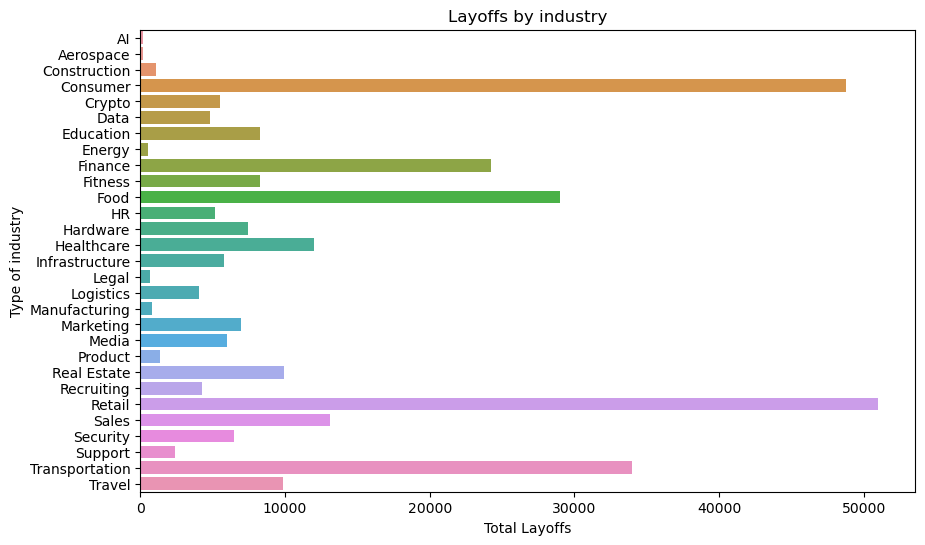

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x='laid_off', y='industry', data=Layoffs_by_industry)
plt.xlabel('Total Layoffs')
plt.ylabel('Type of industry')
plt.title('Layoffs by industry')
plt.show()

# Top 10 Industries with the Highest Layoffs

- We have a more detailed visualization of the technology industries with the highest number of layoffs. It's interesting to note the presence of industries such as Finance and Travel in this top list, considering that we are covering years during which society experienced a pandemic that affected various industries. These industries had to adapt to remain viable despite the challenges they were facing.


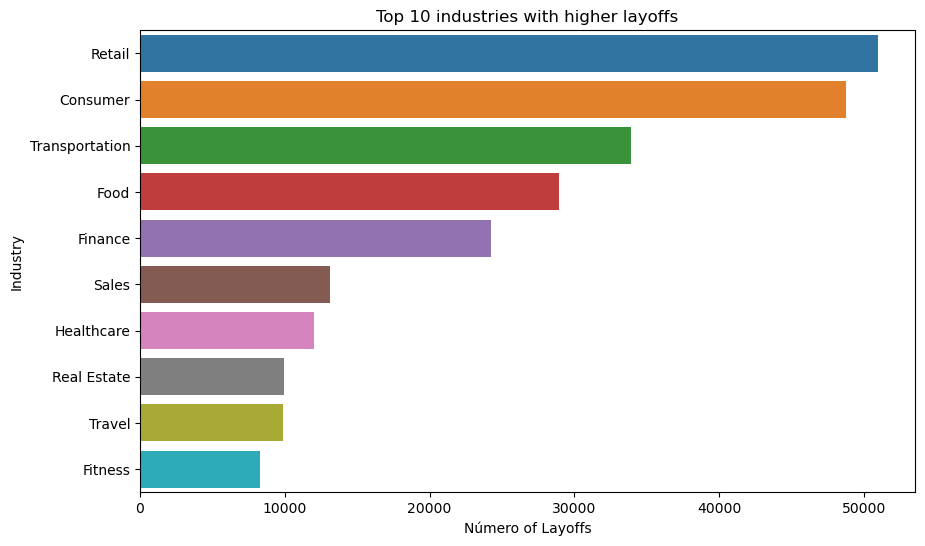

In [12]:
Layoffs_by_industry_laid_off = Tech_Layoffs_EDA.groupby('industry')['laid_off'].sum().reset_index()

Layoffs_by_industry = Layoffs_by_industry_laid_off.sort_values(by='laid_off', ascending=False)

Top_10_industries = Layoffs_by_industry.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='laid_off', y='industry', data=Top_10_industries)
plt.xlabel('Número of Layoffs')
plt.ylabel('Industry')
plt.title('Top 10 industries with higher layoffs')
plt.show()


# Top 10 Industries with the Lowest Layoffs

- From this graph, we can visualize and draw conclusions about trends that have strengthened in the technology sector, showing fewer layoffs throughout 2020 and early 2024.
- It is noteworthy to see the AI industry in this list, considering the significant attention it has received in the past year. Many companies had to adapt to this new trend to gain an edge over their competition, resulting in numerous job opportunities that were previously non-existent and challenging to find, especially in the AI industry.
- Although the dataset refers to AI as an industry, many companies in this sector work on developing software and technologies for other companies across various industries and fields.


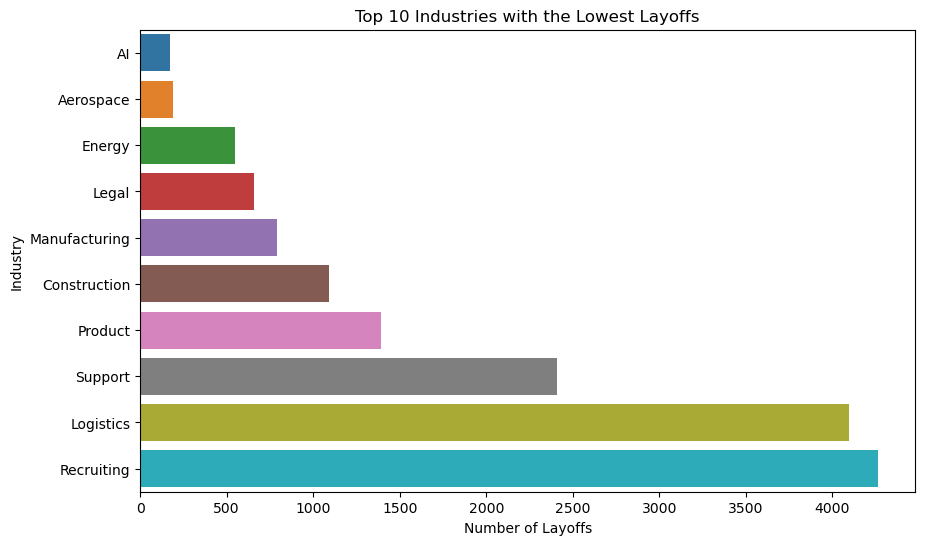

In [13]:
Layoffs_by_industry = Tech_Layoffs_EDA.groupby('industry')['laid_off'].sum().reset_index()

Layoffs_by_industry = Layoffs_by_industry.sort_values(by='laid_off', ascending=True)

Bottom_10_industries = Layoffs_by_industry.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='laid_off', y='industry', data=Bottom_10_industries)
plt.xlabel('Number of Layoffs')
plt.ylabel('Industry')
plt.title('Top 10 Industries with the Lowest Layoffs')
plt.show()


# Analysis of the Total Money Loss by Each Industry

- It is interesting to analyze how not all cases in this dataset show a direct correlation between industries with the highest layoffs and those with the greatest financial loss. For example, the "Media" industry, while not having the highest number of total layoffs, ends up being the industry that suffered the most significant financial loss, surpassing even some of the top 10 industries in terms of layoffs (the Transport industry is the third in total layoffs).
- Note: This analysis will be reinforced with the next graph in our notebook.


In [14]:
Tech_Layoffs_EDA = Tech_Layoffs_EDA[pd.to_numeric(Tech_Layoffs_EDA['money_raised_in_mil'], errors='coerce').notnull()]

Tech_Layoffs_EDA['money_raised_in_mil'] = pd.to_numeric(Tech_Layoffs_EDA['money_raised_in_mil'])

Total_money_raised_industry = Tech_Layoffs_EDA.groupby('industry')['money_raised_in_mil'].sum().reset_index()

Total_money_raised_industry = Total_money_raised_industry.sort_values(by='money_raised_in_mil', ascending=False)
print(Total_money_raised_industry)




          industry  money_raised_in_mil
19           Media             258124.0
27  Transportation             255952.5
3         Consumer             101911.0
10            Food              80883.0
8          Finance              78819.5
23          Retail              41800.0
21     Real Estate              38001.0
13      Healthcare              30359.0
5             Data              22265.0
28          Travel              15951.0
25        Security              15360.0
6        Education              14524.0
18       Marketing              13418.0
16       Logistics              13357.0
4           Crypto              11620.0
9          Fitness               9187.0
24           Sales               6841.0
11              HR               6745.0
20         Product               5839.0
14  Infrastructure               4698.0
26         Support               4237.0
22      Recruiting               3051.0
2     Construction               2900.0
17   Manufacturing               2548.0


# Top 10 Industries with the Highest Money Loss

- This graph, focused solely on the field of money loss, reinforces the previous analysis. Although it may initially seem that there is a direct relationship between the total number of layoffs and the money lost, this is not entirely the case. The top industries in terms of financial loss include sectors that were not prominently featured in the graph of industries with the highest layoffs.


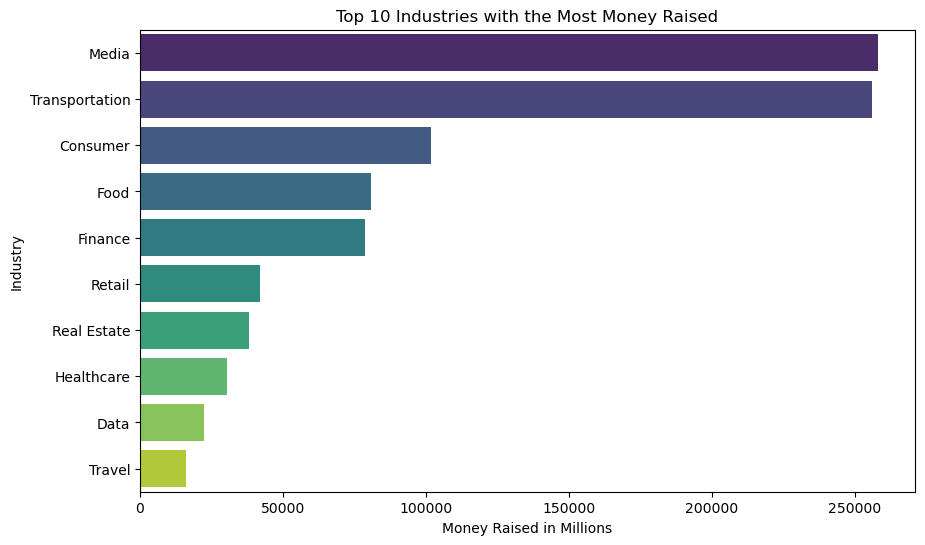

In [15]:
Total_money_raised_industry = Tech_Layoffs_EDA.groupby('industry')['money_raised_in_mil'].sum().reset_index()

Total_money_raised_industry = Total_money_raised_industry.sort_values(by='money_raised_in_mil', ascending=False)

Top_10_industry = Total_money_raised_industry.head(10) 

plt.figure(figsize=(10, 6))
sns.barplot(x='money_raised_in_mil', y='industry', data=Top_10_industry, palette='viridis')
plt.xlabel('Money Raised in Millions')
plt.ylabel('Industry')
plt.title('Top 10 Industries with the Most Money Raised')
plt.show()



# Analysis of the Data Sampling Context
### We can leverage the fields in the dataframe that refer to the location of the records to gain a more specific context and analysis based on where the data in our dataframe was predominantly sourced.
- In this case, we observe that almost all records were extracted from the United States. Analyzing the records by location, the majority are indeed from the United States, supporting the conclusions drawn from this graph.


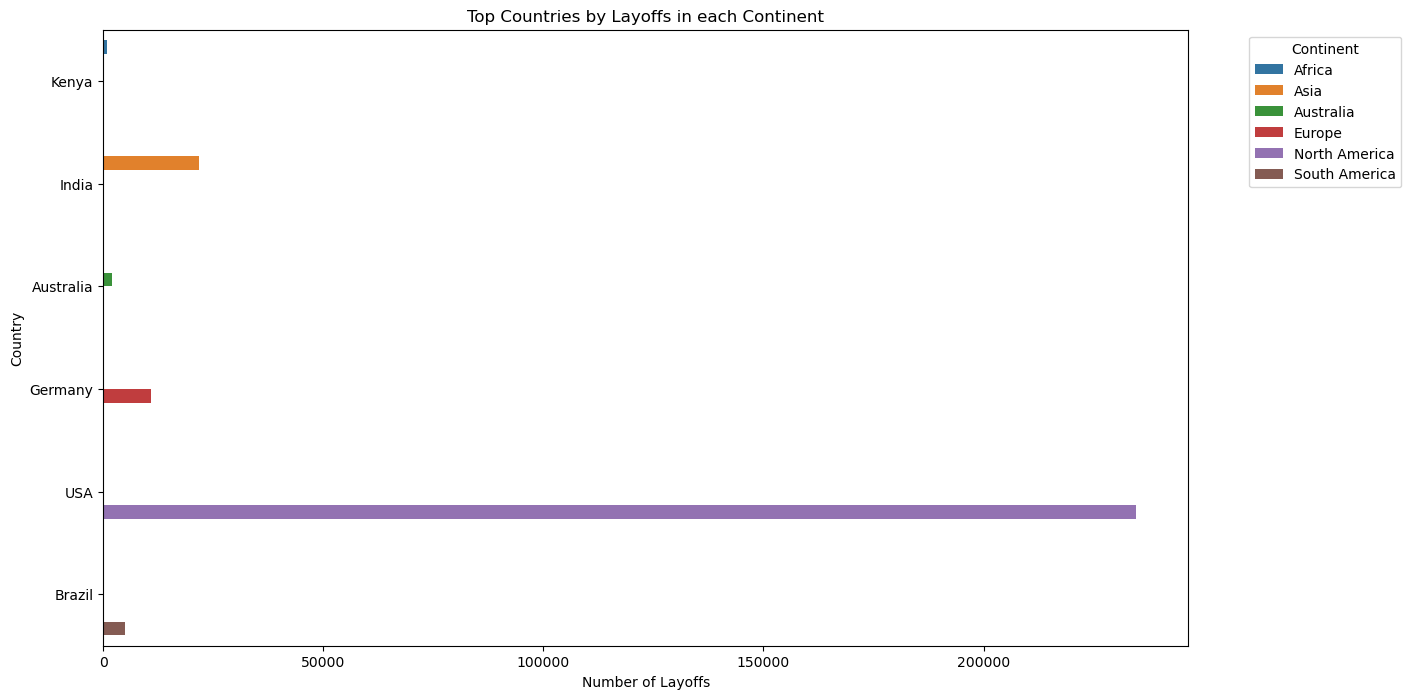

In [16]:
Layoffs_by_country = Tech_Layoffs_EDA.groupby(['continent', 'country'])['laid_off'].sum().reset_index()

Top_countries_by_continent = Layoffs_by_country.loc[Layoffs_by_country.groupby('continent')['laid_off'].idxmax()]

plt.figure(figsize=(14, 8))
sns.barplot(x='laid_off', y='country', hue='continent', data=Top_countries_by_continent)
plt.title('Top Countries by Layoffs in each Continent')
plt.xlabel('Number of Layoffs')
plt.ylabel('Country')
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




# Percentage Bar Chart of Layoffs by Continent

- Although the previous graph illustrates a significant disparity in the number of layoffs by continent (also referencing the number of records in our dataset for each continent), we can complement that graph with a percentage analysis to better understand the proportion of records covered by North America in our dataset.


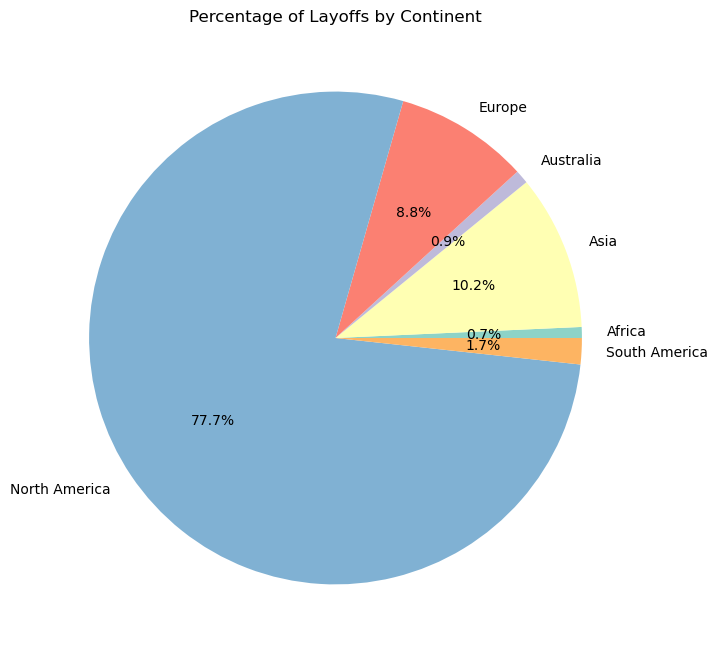

In [17]:
Total_layoffs_by_continent = Layoffs_by_country.groupby('continent')['laid_off'].sum().reset_index()

plt.figure(figsize=(10, 8))
plt.pie(Total_layoffs_by_continent['laid_off'], labels=Total_layoffs_by_continent['continent'], autopct='%1.1f%%', colors=sns.color_palette("Set3"))
plt.title('Percentage of Layoffs by Continent')
plt.show()



# Chart of Each Continent and the Percentage Size Each Country Occupies in the Records of that Continent

- This graph illustrates the size each country occupies within each continent. In most cases, a single country dominates, as evident in the initial graph we created during the analysis of the data sampling context.



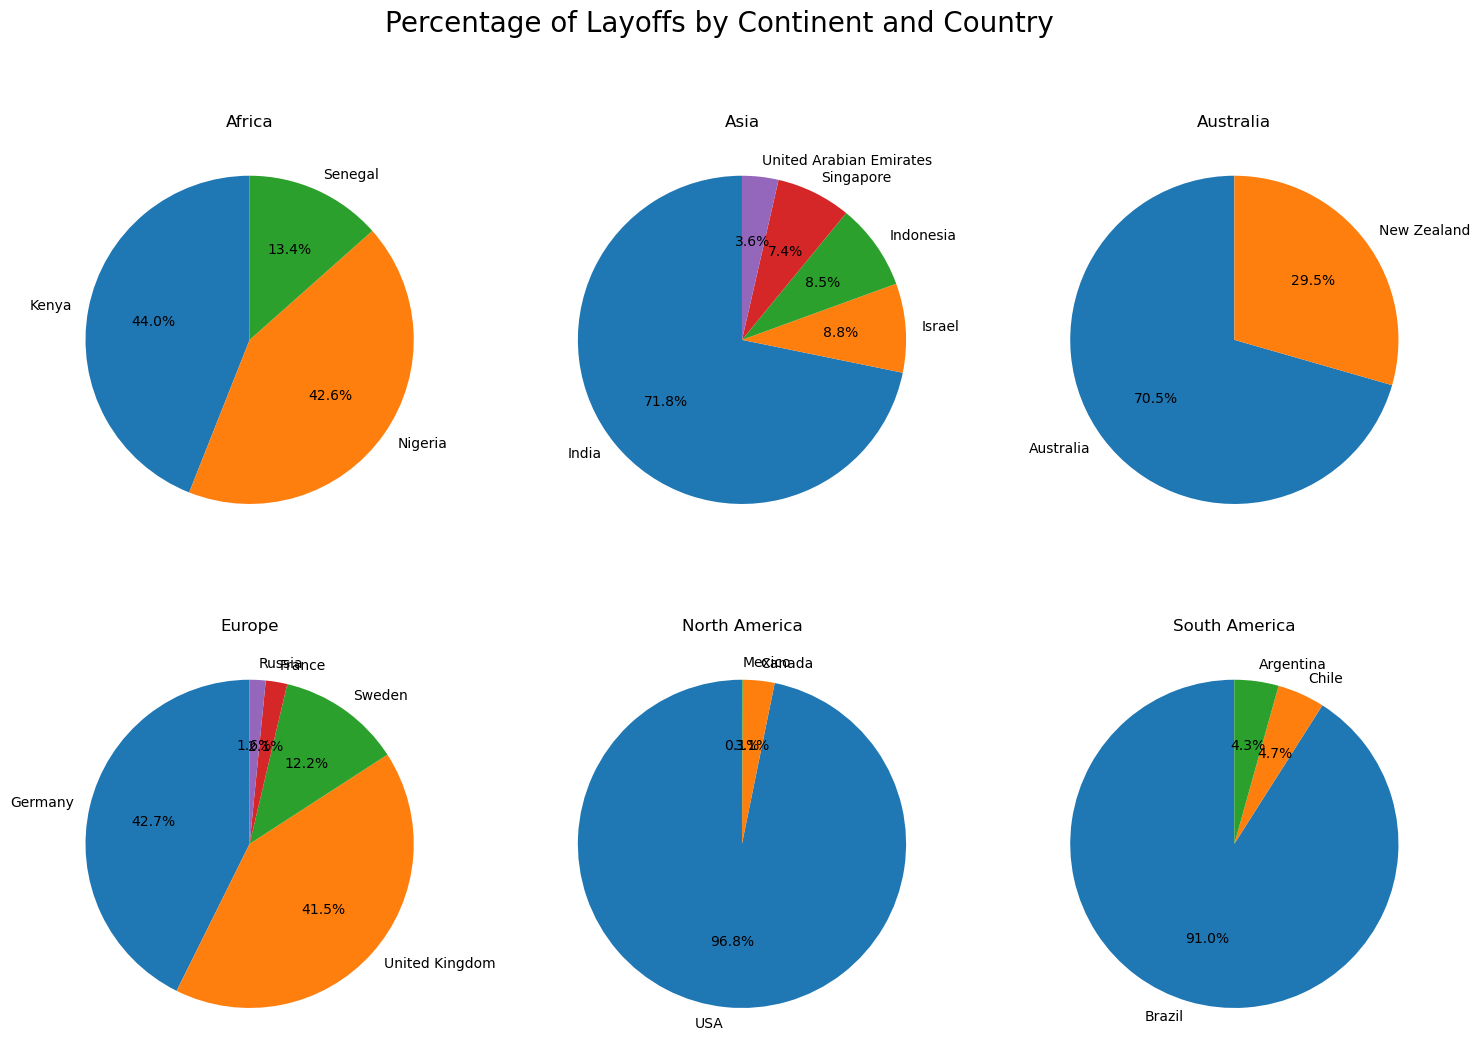

In [18]:
Layoffs_by_country = Tech_Layoffs_EDA.groupby(['continent', 'country'])['laid_off'].sum().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Percentage of Layoffs by Continent and Country', fontsize=20)

for (continent, group), ax in zip(Layoffs_by_country.groupby('continent'), axes.flatten()):
    total_layoffs = group['laid_off'].sum()
    group = group.sort_values(by='laid_off', ascending=False)
    
    group = group.head(5)
    
    group['percentage'] = group['laid_off'] / total_layoffs * 100
    
    ax.pie(group['percentage'], labels=group['country'], autopct='%1.1f%%', startangle=90)
    ax.set_title(continent)

plt.show()





# Locations with the Most Layoffs

- Working with the "Location_hq" field allows us to better understand why the majority of headquarters leading in the highest number of layoffs in this dataset are from the USA. As we analyzed earlier, almost 80% of the records in our dataset are from the North American continent, with 96.8% of these records attributed to a single country, the United States.

- Despite this, the graph surprises us again, with the first headquarters (San Francisco Bay Area) having the highest number of layoffs and a significant lead in records compared to all other headquarters in the dataset. This leads us to consider that data collection for this dataset may have been predominantly focused on this specific geographic area. However, it's important to note that this analysis is not a conclusive statement, as it relies solely on the information available in our dataset.

- Nevertheless, there is an undeniable trend in a specific geographic area.



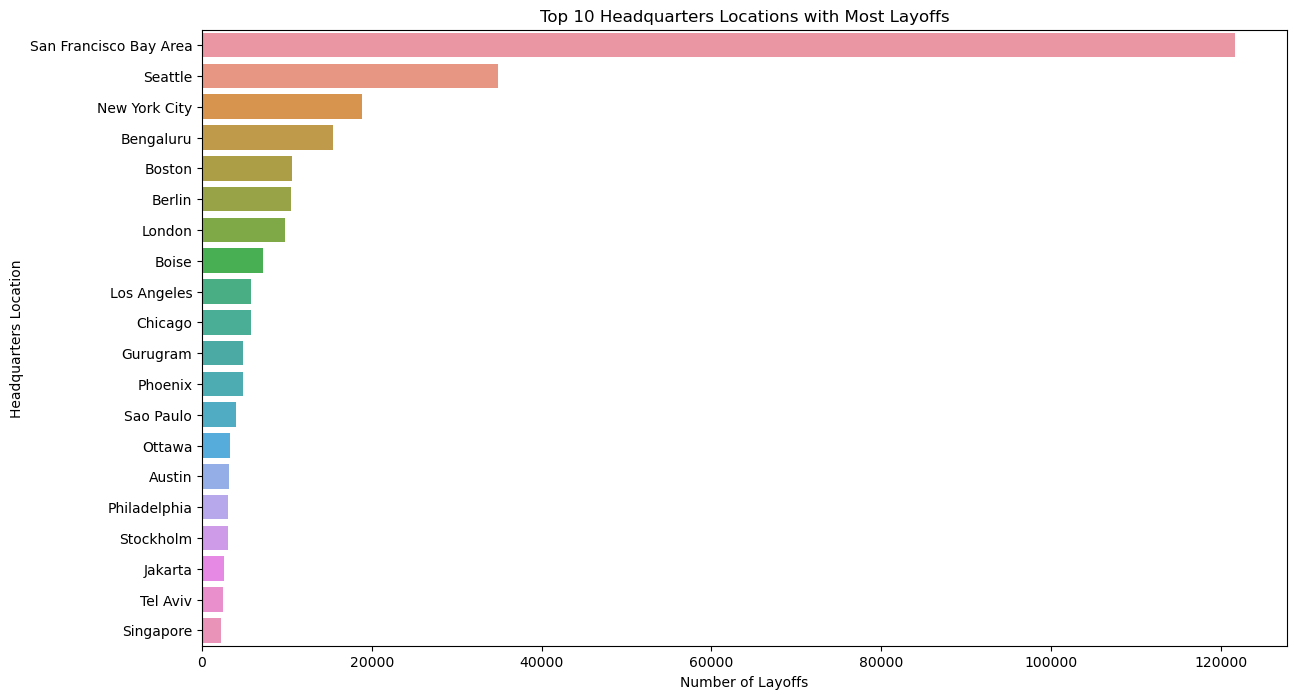

In [19]:
Layoffs_by_location = Tech_Layoffs_EDA.groupby('location_hq')['laid_off'].sum().reset_index()

Top_locations = Layoffs_by_location.sort_values(by='laid_off', ascending=False)

Top_10_locations = Top_locations.head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x='laid_off', y='location_hq', data=Top_10_locations)
plt.title('Top 10 Headquarters Locations with Most Layoffs')
plt.xlabel('Number of Layoffs')
plt.ylabel('Headquarters Location')
plt.show()


# Percentage Chart of the Total Layoffs for Each Headquarters in Our Dataset

- Since we prefer conclusions backed by percentages in addition to raw numbers, we decided to conclude this analysis with a chart showing the percentage of our records corresponding to the singular San Francisco headquarters, encompassing 44% of our entire dataset.

- If we were to analyze the percentage solely for headquarters within the USA, they would cover around 67.9% of the records (considering only the headquarters in San Francisco, Seattle, New York, and Boston).


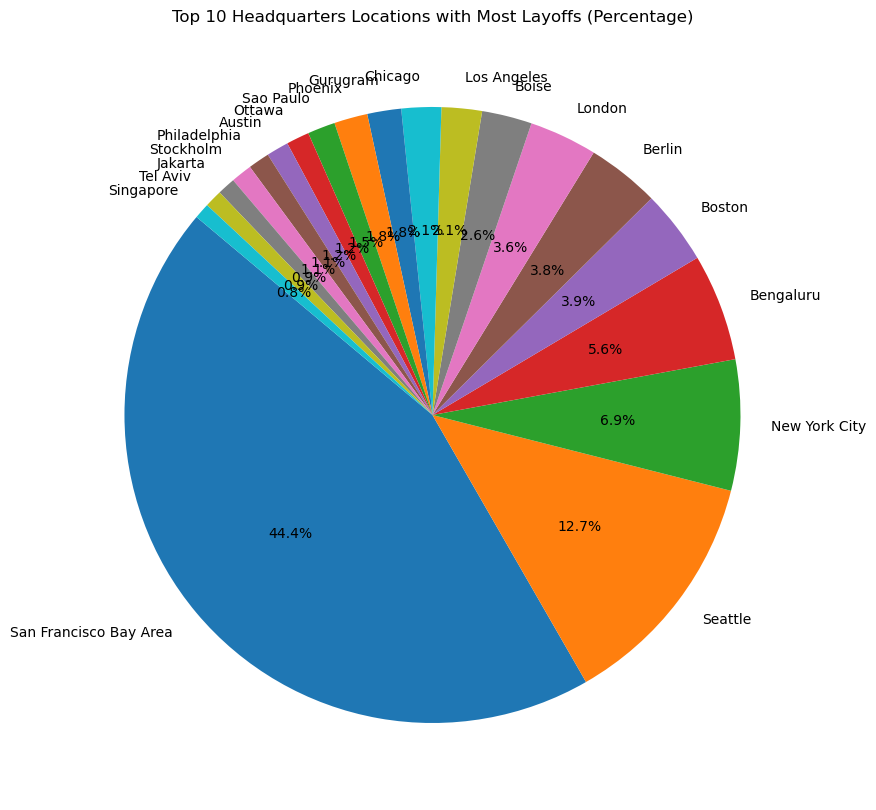

In [20]:
plt.figure(figsize=(10, 10))
plt.pie(Top_10_locations['laid_off'], labels=Top_10_locations['location_hq'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Headquarters Locations with Most Layoffs (Percentage)')
plt.show()


# Analysis of the Temporal Evolution of Layoffs


## Temporal Evolution of Layoffs 2020-2024

- It is interesting to observe that, although years like 2021 and 2024 have very few records, there is a trend where one year significantly leads in the total number of layoffs, and that is 2023. This might be surprising, as it is neither the year with the most layoff records nor does it correspond to the pandemic year of 2020, which witnessed a significant rise in layoffs.

- It should be emphasized that we know that we have two years with too little data (2021 and 2024) and that perhaps trends that can be inferred from this graph as "The year 2021 was the year with fewer numbers of desipids" by the behavior of the graph, is a conclusion that we have to discard already knowing that these years alone give us value in some specific analyses but in others they may mark a low number in the evolution of the data and this is only by the so low number of records with which our dataset


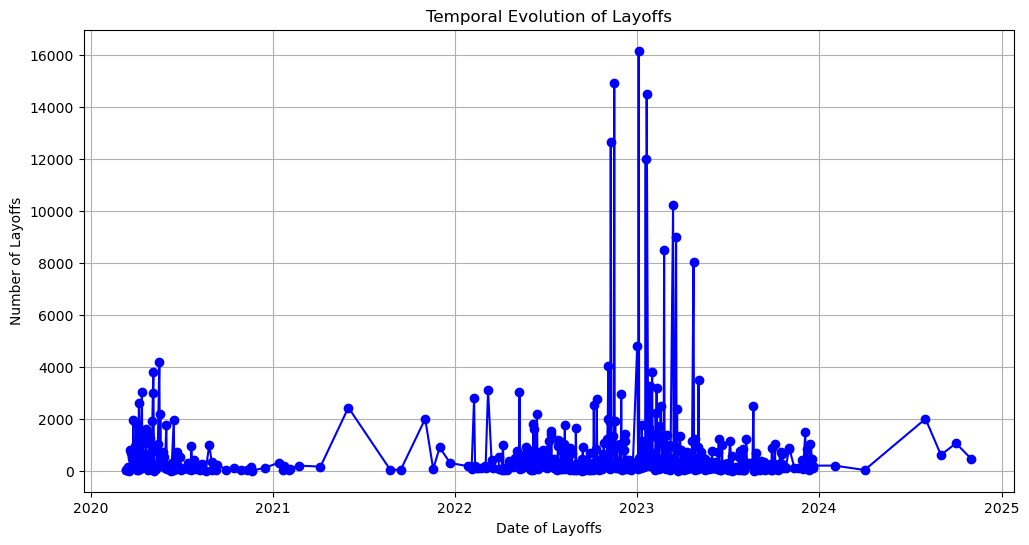

In [21]:
Tech_Layoffs = Tech_Layoffs.sort_values(by='date_layoffs')

Layoffs_by_date = Tech_Layoffs.groupby('date_layoffs')['laid_off'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(Layoffs_by_date['date_layoffs'], Layoffs_by_date['laid_off'], marker='o', linestyle='-', color='b')
plt.title('Temporal Evolution of Layoffs')
plt.xlabel('Date of Layoffs')
plt.ylabel('Number of Layoffs')
plt.grid(True)
plt.show()
